# <span style="color:blue"> Machine Learning con Applicazioni </span>
#### Andrea Sala - 983944


### <span style = "color:darkred"> Introduzione </span>
Il dataset scelto per questo progetto consiste in circa 6000 entries riguardanti alcune bottiglie di vino bianco e rosso della variante Vinho Verde. Ogni bottiglia è caratterizzata da 12 variabili di input, corrispondenti alle caratteristiche chimico-fisiche del vino, e da una variabile di output di tipo sensoriale (un punteggio dato dai sommelier all'apertura della bottiglia). L'obiettivo di questo studio è quello di allenare un predittore attraverso diversi algoritmi di supervised learning. Il predittore dovrebbe essere in grado di classificare il vino - ovvero predirre il suo punteggio- prese in ingresso le variabili di input. In altre parole, si cerca di scoprire se esiste una dipendenza funzionale dello score dalle variabili fisico-chimiche della bottiglia di vino.

### <span style="color:darkred"> Caricamento del dataset e preprocessing</span>

Il dataset è stato caricato da un file ```.csv``` disponibile gratuitamente sulla piattaforma _Kaggle_, e immaganizzato in un ```pandas.DataFrame```. Inoltre, per chiarezza, la variabile di output è stata rinominata _score_, mentre la variabile _style_ (_red_,_white_) è stata resa una variabile binaria (0,1). 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
import time
from IPython.display import Image
from tqdm.notebook import tqdm

plt.style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')

In [2]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [3]:
fileName = "wine_dataset.csv"
df = pd.read_csv(fileName)
df['style'] = df['style'].replace('red', 0)
df['style'] = df['style'].replace('white',1)
df['score'] = df['quality']
df['score'].astype(int)
del df['quality']
y = df['score']
print(df.shape)

(6497, 13)


La variabile di output presenta una distribuzione non isotropa, ma centrata molto sui punteggi nell intervallo \[5,7\]: questo renderà più difficile predirre gli output con punteggio molto alto (8) o molto basso (3).

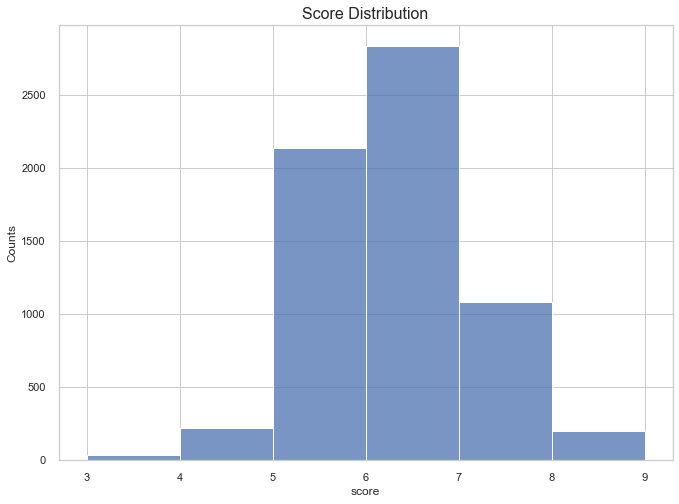

In [4]:
sns.set(style = 'whitegrid', rc={'figure.figsize':(11,8)})
ax = sns.histplot(df['score'], bins=6, kde=False, stat='count')
ax.set_ylabel("Counts")
ax.set_xlabel("score")
ax.set_title("Score Distribution", fontsize=16)
plt.show()

<AxesSubplot:xlabel='score', ylabel='count'>

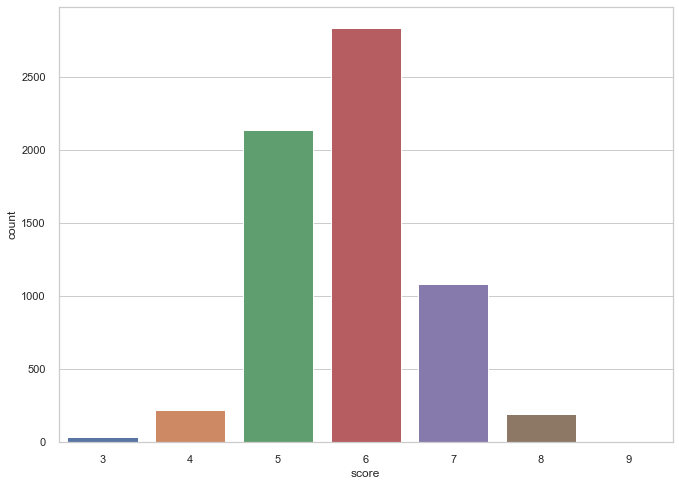

In [5]:
sns.countplot(df['score'])

### <span style="color:darkred"> Tecniche di oversampling: SMOTE </span>

Come si può vedere dal grafico poco sopra, le classi non sono per nulla bilanciate. In particolare, solo le tre classi centrali (con punteggio 5, 6, 7) presentano un numero adeguato di entries, mentre le altre classi presentano un bassissimo numero di dati. Questo _imbalance_ è dannoso per gli algoritmi che andrò ad allenare, in quanto avranno a disposizione troppi pochi dati per imparare a riconoscere i dati appartenenti alle classi più povere.

Per questo motivo ho fatto uso di tecniche di oversampling, in particolare di _SMOTE_ (Synthetic Minority Over-sampling TEchnique). Questa tecinca va a campionare nuovi dati per le classi di minoranza, secondo questo procedimento:

- Viene preso un dato appartenente ad una classe minoritaria e vengono calcolati i suoi primi k vicini
- Viene scelto uno a caso tra questi k vicini e si traccia il segmento che congiunge questi due punti nello spazio dei parametri
- Viene estratto un punto a caso che giace su questo segmento: questo è il nuovo dato classificato con lo stesso label del dato di partenza

In questo modo la distribuzione del dataset cambia e diventa molto più bilanciata, facilitando il lavoro ai predittori che userò in questo studio. Per decidere quanti dati dovevano venire ricampionati, ho scleto dei numeri che mi garantissero che la distribuzione finale fosse piccata al centro ma ben distribuita (vedi figura sotto).

In [6]:
from imblearn.over_sampling import SMOTE, RandomOverSampler
train_cols = ['fixed_acidity','volatile_acidity','citric_acid','residual_sugar','chlorides',
               'free_sulfur_dioxide','density','pH','sulphates','alcohol', 'style']
X = df[train_cols]
y = df['score']
weights = {3:800, 4:1500, 5:2300, 6:2836, 7:1800, 8:1200, 9:300}
oversample = SMOTE(k_neighbors=4, sampling_strategy=weights)
# transform the dataset
XX, YY = oversample.fit_resample(X, y)
XX.shape

(10736, 11)

<AxesSubplot:xlabel='score', ylabel='count'>

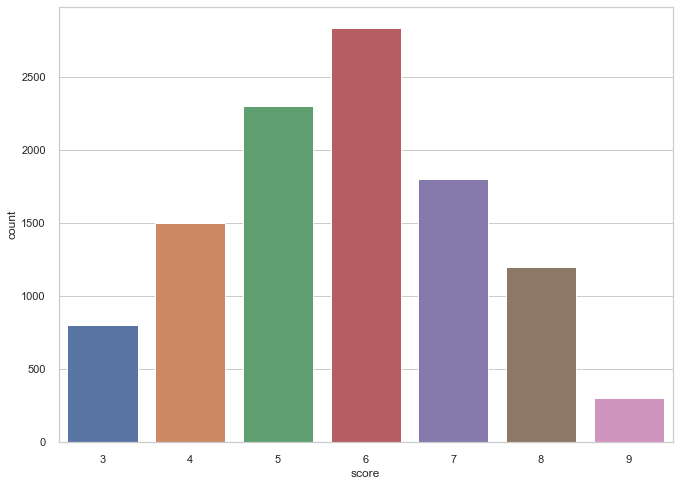

In [7]:
sns.countplot(YY)

### <span style="color:darkred"> Matrice di correlazione </span>
Ho calcolato e rappresentato la matrice di correlazione tra tutte le variabili presenti nel dataset. Come si vede in figura, tutte le varibili di input sono tra loro poco correlate; si è scelto di rimuovere solo la variabile _total\_sulfur\_dioxide_  perché presenta due coefficienti di correlazione alti  (>0.7) con due altre variaibli di input.

Un problema che emerge dal plot della matrice di correlazione è che nessuna delle variabili di input presenta coefficienti di correlazione lineare elevati con la variabile _score_. Dalla matrice di correlazione possiamo quindi estrarre due informazioni:
- Il metodo della regressione lineare può essere scartato a priori, in quanto si basa su combinazioni lineari delle variabili di input per costruire un predittore, ma combinando linearmente queste variabili di input è molto difficile ottenere la forma funzionale dell'output.
- In ogni caso, non ci dovremo aspettare degli _score_ troppo alti per gli algoritmi che andremo ad allenare, in quanto il dataset mostra poche correlazioni con la variabile di output.

<AxesSubplot:>

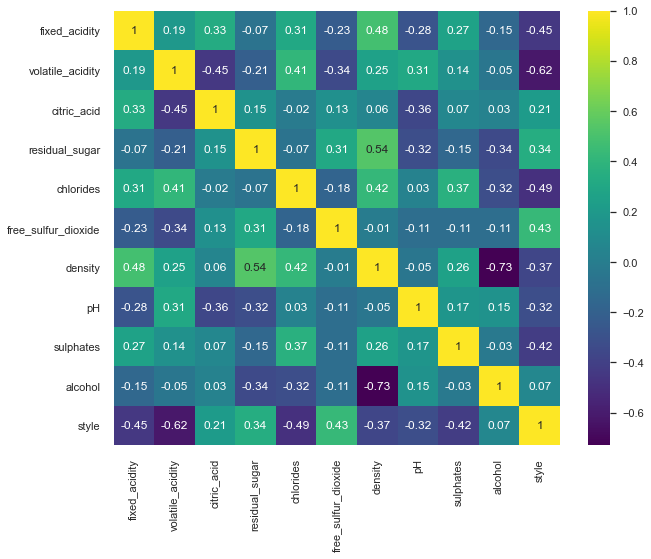

In [8]:
CorMat = XX.corr().round(2)
fig = plt.figure(figsize=(10,8))
sns.heatmap(data=CorMat, annot=True, cmap='viridis')

Successivamente, ho diviso il dataset in _training_ e _test_ per poi procedere all'allenamento di alcuni semplici algoritmi di supervised learning.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(XX, YY, train_size=0.8)
                                                   
print(X_train.shape, X_test.shape)

(8588, 11) (2148, 11)


### <span style="color:darkred"> Support Vector Machine </span>

Il primo predittore che ho usato è un Support Vector Classifier (SVC). Questo è un predittore lineare, che va a costruire un iperpiano di separazione tra le classi (confrontando una coppia di classi alla volta, in gergo _one versus one_)

$$f(x) = x^T\beta + \beta_0 = 0 $$

Il problema di minimizzazione nel caso di classi non completamente separabili è 
$$ \min_{\mathbb{R}^p} \beta \quad : \quad y_i (x_i^T\beta + \beta_0) \geq M (1-\xi_i)$$
con i vincoli 
$$\xi_i\geq0 \quad\mbox{e}\quad \Sigma \xi_i \leq C$$
Le variabili $\xi_i$ sono dette _slack variables_ e sono quelle che permettono a determinati punti di giacere dalla parte sbagliata dell'iperpiano di separazione. Le misclassificazioni si hanno per $\xi_i > 1$, ma il parametro $C$ limita il numero massimo di misclassificazioni con il vincolo $\Sigma \xi_i\leq C$.
<img src="SVMplot.png"
     alt="Markdown Monster icon"
     width = "300px"/>

Nonostante un classificatore SVC sia per definizione lineare, posso estendere questo algortitmo ad un caso di separazione non lineare grazie all'utilizzo di kernel non lineari. Ho provato ad allenare quattro diversi SVC, con kernel rispettivamente:
- lineare - $K(x,x') = \langle x,x'\rangle$
- radial basis function -  $K(x,x')=\exp(-\gamma ||x-x'||^2)$
- polinomiale di grado 3 -  $K(x,x')=(1 + \langle x,x'\rangle)^3$
- kernel a sigmoide - $K(x,x') = \tanh (\gamma \langle x,x'\rangle + c)$

I risultati di accuracy sul dataset di test sono mostrati di seguito.

In [10]:
from sklearn import svm

In [13]:
svm_lin = svm.SVC(kernel='linear', C=10, decision_function_shape='ovo').fit(X_train, y_train)
score = svm_lin.score(X_test,y_test)
print("SVM score with linear kernel: {}".format(score))

SVM score with linear kernel: 0.44599627560521415


In [13]:
svm_rbf = svm.SVC(kernel='rbf', C=5, gamma=1,decision_function_shape='ovo').fit(X_train, y_train)
score = svm_rbf.score(X_test,y_test)
print("SVM score with RBF kernel: {}".format(score))

SVM score with RBF kernel: 0.744413407821229


In [15]:
svm_poly = svm.SVC(kernel='poly', C=5, degree=4, decision_function_shape='ovo').fit(X_train, y_train)
score = svm_poly.score(X_test,y_test)
print("SVM score with polynomial kernel: {}".format(score))

SVM score with polynomial kernel: 0.3538175046554935


In [16]:
svm_fitter = svm.SVC(kernel='sigmoid', C=10, gamma=2.5, decision_function_shape='ovo').fit(X_train, y_train) 
score = svm_fitter.score(X_test, y_test)
print("SVM score with sigmoid kernel: {}".format(score))

SVM score with sigmoid kernel: 0.2770018621973929


Si osserva che le prestazioni dell'algoritmo sono tendenzialmente basse, indice del fatto che non è facile allenare un SVC su un dataset di questo tipo. In ogni caso, le prestazioni migliori sono offerte dal Support Vector Machine con **kernel a base radiale**. Ho quindi scelto di concentrarmi su questo algoritmo e cercare di ottimizzarne i parametri.

##### <span style="color:darkred"> Kernel RBF - Ottimizzazione dei parametri </span>

Il parametro $\gamma$ è quello all'interno del kernel 
$$ K(x,x') = \exp(-\gamma ||x-x'||^2) $$

Ho allenato l'algoritmo scegliendo $\gamma$ diversi e osservando per quale valore di $\gamma$ l'accuracy sul training set è massimizzata. I risultati in realtà sono abbastanza simili, ma lo score più alto è dato da $\gamma=10$

Il parametro $C$ del Support Vector Machine è quello responsabile dell'ampiezza della banda di separazione. Un margine di separazione stretto corrisponde a $C$ grande, ovvero tengo basso il numero di $\xi_i>0$ e impedisco le misclassificazioni. Il rischio di tenere $C$ grande è quello di avere un margine di separazione frastagliato e di andare in **overfitting**. 
Viceversa, avere $C$ piccolo signfica permettere più misclassificazioni ed avere quindi un boundary più liscio: si introduce un bias ma si evita l'overifitting. La scelta ottimale è evidentemente una via di mezzo tra questi due poli, ma per capire il parametro migliore è stato necessario provare alcune configurazioni e vedere quale produce lo score più alto.

In [17]:
gammas = [0.1, 1.0, 2.5, 5, 7.5, 10, 20]
Cs = [0.01, 0.1, 0.5, 1.0, 2.5, 5, 10, 20]
gBest, cBest, scoreBest = gammas[0], Cs[0], 0

scores = np.zeros((len(gammas),len(Cs)))
trScores = np.zeros((len(gammas),len(Cs)))

for i,c in tqdm(enumerate(Cs), total=len(Cs)):
    for j,g in tqdm(enumerate(gammas), total=len(gammas), leave=False):
        fitter =  svm.SVC(kernel='rbf', gamma=g, C=c, decision_function_shape='ovo').fit(X_train, y_train)
        trPred, tsPred = fitter.predict(X_train), fitter.predict(X_test)
        scores[j][i] = accuracy_score(tsPred,y_test)
        trScores[j,i] = accuracy_score(trPred,y_train)
        if (scores[j][i]>scoreBest):
            scoreBest = scores[j][i]
            gBest, cBest = g, c
        

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

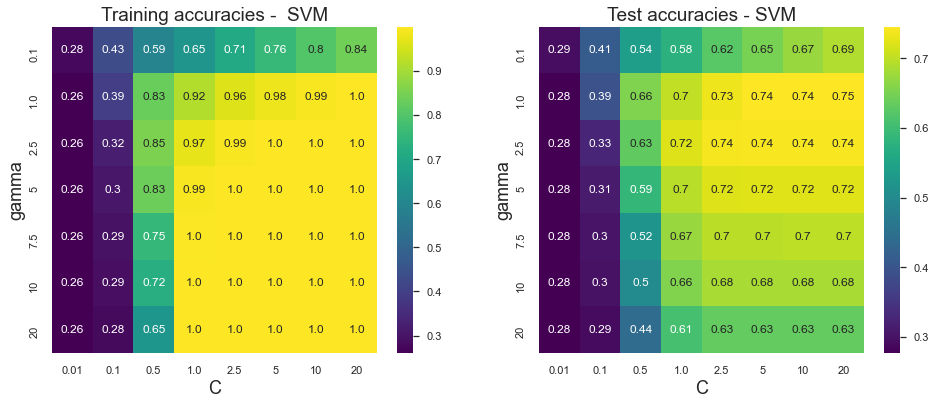

In [18]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(16,6))

ax1 = sns.heatmap(trScores, annot=True, ax=ax1, xticklabels = Cs, yticklabels=gammas, fmt='.2', cmap='viridis')
ax1.set_title("Training accuracies -  SVM", fontsize = 19)
ax1.set_ylabel("gamma", fontsize = 18)
ax1.set_xlabel("C", fontsize = 18)


ax2 = sns.heatmap(scores, annot=True, ax=ax2, xticklabels = Cs, yticklabels=gammas, fmt='.2', cmap='viridis')
ax2.set_title("Test accuracies - SVM", fontsize = 19)
ax2.set_ylabel("gamma", fontsize = 18)
ax2.set_xlabel("C", fontsize = 18)
plt.show()

In [19]:
print("Support Vector Machine - Best Model: ")
print("C: {:2}".format(cBest))
print("Gamma: {:2}".format(gBest))
print("Accuracy: {:.4}".format(scoreBest))

Support Vector Machine - Best Model: 
C: 20
Gamma: 1.0
Accuracy: 0.7453


I risultati mettono in mostra che la configurazione migliore di algoritmo SVC si ottiene con i parametri $\gamma$ =10, C=5 . In questo modo si ottiene una accuracy di 0.62, che non è molto buona, ma comunque un risultato discreto visti anche i risultati degli altri Support Vector Classifier.

### Decision Tree Classifiers

In [20]:
from sklearn.tree import DecisionTreeClassifier

Un _Decision Tree Classifier_ è un algoritmo che permette di andare a classificare dei dati attraverso una successione di divisioni binarie. Il modello impara a predirre i valori della variabile di target costruendo delle regole decisionali sulle variabili di input. Questo processo di suddivisione viene iterato finché non si è riuscito a separare le classi in intervalli (idealmente) disgiunti nello spazio dei parametri.

Alcuni dei parametri regolabili all'interno di un Decision Tree Classifier sono:

- criterion: La funzione costo "locale" per misurare l'impurità di ciascun nodo dell'albero. In questo lavoro è stato usato l'indice di impurità d Gini.
- max_depth: La profondità massima dell'albero.
- min_samples: numero minimo di dati in un nodo.
- max_features: Il massimo numero di features da usare per lo splitting del nodo.
- min_impurity_decrease: Uno split avviene se induce una riduzione dell'impurità maggiore o uguale a questo valore.
- ccp_alpha: Parametro di pruning (vedi sotto)


Il parametro di pruning $ccp_\alpha$ è dato dalla teoria di Minimal Cost-Complexity Pruning.
Questo parametro è usato per definire la misura di cost-complexity $R_\alpha(T)$ per un albero $T$:
$$ R_\alpha(T) = R(T) + \alpha |\tilde{T}| $$
con $|\tilde{T}|$ numero di nodi terminali in un albero, e $R(T)$ è il tasso di classificazioni errate nei nodi terminali. 

Si definisce per ogni nodo la quantità $\alpha_{\mbox{eff}}$, che è il valore per cui l'impurità di un singolo nodo è uguale alla somma delle impurità alla stessa profondità:
$$  $$

Il processo di Minimal Cost-Complexity Pruning consiste nella potatura del nodo con minore $\alpha_{\mbox{eff}}$ ad ogni step. Il processo si ferma quando tutti gli $\alpha_{\mbox{eff}}$ rimasti sono maggiori del parametro $ccp_\alpha$.

Ho provato ad allenare un singolo Decision Tree con diverse scelte del parametro di pruning e della massima profondità dell'albero. I risultati sul test set sono mostrati in figura:

In [21]:
max_depths = [1+4*d for d in range(0,10)]
ccps = [0, 0.00001, 0.001, 0.01, 0.1, 1]

top_depth, top_ccp = max_depths[0], ccps[0]
topScore = 0
treeScores = np.zeros((len(ccps),len(max_depths)))
treeScoresTrain = np.zeros((len(ccps),len(max_depths)))

for j,md in tqdm(enumerate(max_depths),total=len(max_depths)):
    for i,pr in tqdm(enumerate(ccps),total=len(ccps), leave=False):
        
        tree = DecisionTreeClassifier(criterion='gini', max_depth=md, ccp_alpha=pr, random_state=3*i*j).fit(X_train, y_train)
        thisScore = tree.score(X_test,y_test)
        
        predicted = tree.predict(X_test)
        treeScoresTrain[i,j] = tree.score(X_train,y_train)
        treeScores[i,j] = thisScore

        
        if (thisScore > topScore):
            top_depth, top_ccp, topScore = md, pr, thisScore

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

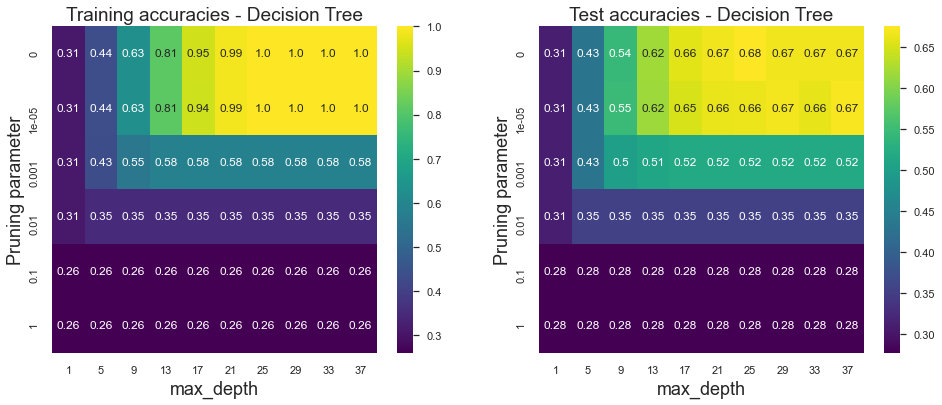

In [22]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(16,6))

ax1 = sns.heatmap(treeScoresTrain, annot=True, ax=ax1, xticklabels = max_depths, yticklabels=ccps, fmt='.2', cmap='viridis')
ax1.set_title("Training accuracies - Decision Tree", fontsize = 19)
ax1.set_ylabel("Pruning parameter", fontsize = 18)
ax1.set_xlabel("max_depth", fontsize = 18)


ax2 = sns.heatmap(treeScores, annot=True, ax=ax2, xticklabels = max_depths, yticklabels=ccps, fmt='.2', cmap='viridis')
ax2.set_title("Test accuracies - Decision Tree", fontsize = 19)
ax2.set_ylabel("Pruning parameter", fontsize = 18)
ax2.set_xlabel("max_depth", fontsize = 18)
plt.show()

Si osserva che i risultati migliori si ottengono con un parametro di pruning tenuto a zero, e con una profondità massima dell'albero di 36. Notare che avere una profondità massima grande a piacere non migliora le prestazioni dell'algoritmo, perché si cade come al solito in un regime di overfitting. Tenendo conto che un singolo albero è un predittore debole, una accuracy di 0.68 è un risultato buono, che indica che le prestazioni di questo algoritmo sono state sfruttate al massimo. Il risultato ottenuto è paragonabile a quello ottenuto con SVM, ma viene raggiunto in un tempo computazionale estremamente inferiore.

In [29]:
print("Decision Tree Classifier - Best Model: ")
print("Max depth: {}".format(top_depth))
print("Pruning parameter: {}".format(top_ccp))
print("Accuracy: {:.4}".format(topScore))

Decision Tree Classifier - Best Model: 
Max depth: 25
Pruning parameter: 0
Accuracy: 0.6755


### Random Forest

In [24]:
from sklearn.ensemble import RandomForestClassifier

Un _Random Forest classifier_ è un algoritmo che utilizza un insieme di Decisional Trees per costruire un prdittore più robusto. Calcolando il valor medio dei risultati trovati con i singoli alberi decisionali, esso cerca di migliorare l'accuracy di predizione sul dataset. Il costruttore RandomForestClassifier prende in ingresso molti parametri; di questi, io mi sono concentrato sul numero di alberi all'interno della foresta e sulla profondità massima di ogni albero.

Facendo variare questi due parametri ho cercato la cofigurazione più efficiente per predirre lo score sulle bottiglie di vino presenti nel mio dataset.

In [25]:
Ntrees = [5,10,20,50,100,200,500,1000]
Depth = [1+4*d for d in range(0,10)]

topN, topMaxDepth, topRFScore = max_depths[0], ccps[0], 0

TestAcc = np.zeros((len(Depth), len(Ntrees)))
TrainAcc = np.zeros((len(Depth), len(Ntrees)))
for j,n in tqdm(enumerate(Ntrees), total=len(Ntrees)):
    for i,d in enumerate(Depth):
        RT = RandomForestClassifier(n_estimators=n, bootstrap=True, criterion='gini', max_depth=d)
        RT.fit(X_train,y_train)
        TestAcc[i,j] = RT.score(X_test,y_test)
        TrainAcc[i,j] = RT.score(X_train, y_train)
        
        if (TestAcc[i,j] > topRFScore):
            topN, topMaxDepth, topRFScore = n, d, TestAcc[i,j]

  0%|          | 0/8 [00:00<?, ?it/s]

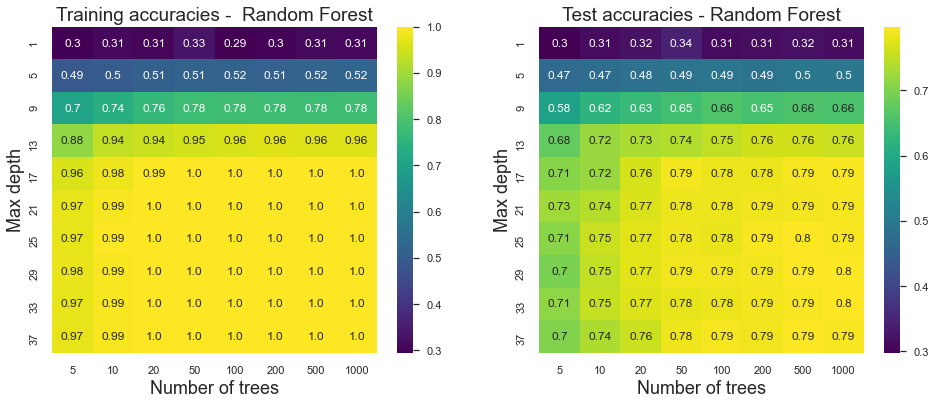

In [27]:
f,(ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

ax1 = sns.heatmap(TrainAcc, annot=True, ax=ax1, xticklabels = Ntrees, yticklabels=Depth, fmt='.2', cmap='viridis')
ax1.set_title("Training accuracies -  Random Forest", fontsize = 19)
ax1.set_xlabel("Number of trees", fontsize = 18)
ax1.set_ylabel("Max depth", fontsize = 18)



#fig, ax = plt.subplots(figsize = (10, 6))
ax2 = sns.heatmap(TestAcc, annot=True, ax=ax2, xticklabels = Ntrees, yticklabels=Depth, fmt='.2', cmap='viridis')
ax2.set_title("Test accuracies - Random Forest", fontsize = 19)
ax2.set_xlabel("Number of trees", fontsize = 18)
ax2.set_ylabel("Max depth", fontsize = 18)
plt.show()

In [30]:
print("Random Forest Classifier - Best Model: ")
print("Max depth: {}".format(topMaxDepth))
print("Number of estimators: {}".format(topN))
print("Accuracy: {:.4}".format(topRFScore))

Random Forest Classifier - Best Model: 
Max depth: 33
Number of estimators: 1000
Accuracy: 0.7975


Gli algoritmi di Random Forest presentano risultati migliori sia rispetto al singolo albero decisionale, che rispetto al Support Vector Machine. Infatti, si riesce a costruire un algoritmo che garantisce uno score di circa 80% quando messo alla prova sul test set. Bisogna altresì notare che la precisione con cui lo score del vino viene stimata con l'algoritmo Random Forest Classifier viene raggiunta al prezzo di un tempo di computazione superiore.

### Gradient Boosting Classifier

In [28]:
from sklearn.ensemble import GradientBoostingClassifier

L'ultimo algoritmo che è stato usato per predirre lo score delle bottiglie di vino è stato il _Gradient Boosting Classifier_.

Il Gradient Boosting Classifier (chiamato anche Boosted Decision Tree) è un algoritmo simite al Random Forest, nel senso che combina un insieme di Decision Tree. La differenza sostanziale sta nel fatto che l'algoritmo pesa i classificatori in base ai risultati di tutti i classificatori precedenti. Ogni algoritmo prova a migliorare le proprie performance assegnando un peso maggiore alle predizioni errate e la funzione di loss viene minimizzata albero dopo albero. Il modello finale sarà quindi dato dalla media pesata degli output di tutti i classificatori.

Nello studio di questo algoritmo ho analizzato i seguenti parametri:

- loss:  la funzione di loss, è stata utilizzata la *deviance*, ovvero la classificazione secondo una regressione logistica
- n_estimators: numero di alberi decisionali utilizzati.

- subsample:  sottoinsieme di dati da utilizzare ad ogni step. 

- max_depth:  profondità massima di ogni albero.

- ccp_alpha:  parametro di pruning (v. Sezioni precedenti). In questo caso è stato messo pari a $10^{-5}$



In [ ]:
max_depth = [1+4*d for d in range(0,6)]
n_trees = [5,10,20,50,100,200]#,500,1000]

topScoreGBC, topD, topNt = 0, max_depth[0], n_trees[0]

GBC_Test_Scores = GBC_Train_Scores = np.zeros((len(max_depth), len(n_trees)))

for i, dep in tqdm(enumerate(max_depth), total=len(max_depth)):
    for j, n in tqdm(enumerate(n_trees), total=len(n_trees), leave=False):
        
        fitter = GradientBoostingClassifier(n_estimators=n, max_depth=dep, loss='deviance').fit(X_train,y_train)
     
        GBC_Train_Scores[i,j] = fitter.score(X_train,y_train)
        GBC_Test_Scores[i,j] = fitter.score(X_test,y_test)
        
        if (GBC_Test_Scores[i,j] > topScoreGBC):
            topNt, topD, topScoreGBC = n, d, GBC_Test_Scores[i,j]
          

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
f,(ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

ax1 = sns.heatmap(GBC_Train_Scores, annot=True, ax=ax1, xticklabels = n_trees, yticklabels=max_depth, fmt='.2', cmap='viridis')
ax1.set_title("Training accuracies -  Gradient Boosting Classifier", fontsize = 19)
ax1.set_xlabel("Number of trees", fontsize = 18)
ax1.set_ylabel("Max depth", fontsize = 18)



#fig, ax = plt.subplots(figsize = (10, 6))
ax2 = sns.heatmap(GBC_Test_Scores, annot=True, ax=ax2, xticklabels = n_trees, yticklabels=max_depth, fmt='.2', cmap='viridis')
ax2.set_title("Test accuracies - Gradient Boosting Classifier", fontsize = 19)
ax2.set_xlabel("Number of trees", fontsize = 18)
ax2.set_ylabel("Max depth", fontsize = 18)
plt.show()

In [ ]:
print("Random Forest Classifier - Best Model: ")
print("Max depth: {}".format(topD))
print("Number of estimators: {}".format(topNt))
print("Accuracy: {:.4}".format(topScoreGBC))

Sorprendentemente, l'algoritmo di Gradient Boosting non riesce a superare le prestazioni sul test set rispetto al Random Forest. Questo significa che già con il Random Forest si erano sfruttate al massimo le correlazioni all'interno del dataset e probabilmente non si riesce ad ottenere una predizione migliore. Ricordiamo infatti che lo score sulle bottiglie di vino è stato dato a livello sensoriale, dunque non è detto che ci sia una correlazione stretta tra le variabili di input e lo score. Tutti gli algoritmi che ho provato non riescono a superare uno score del 70%, quindi posso supporre che questo sia il massimo che si riesce ad estrarre dal dataset

###  <span style="color:darkred"> PCA e riduzione dimensionale </span>

Alla fine, ho cercato di analizzare il dataset dal punto di vista della riduzione dimensionale, sfruttando il potente algoritmo della Principal Component Analysis. L'idea sottostante alla PCA è quella di identificare le variabili di input corrispondenti alla maggiore varianza, ovvero quali variabili hanno una distribuzione più singnificativa. Prima di tutto, per applicare la PCA è necessario che la matrice di design sia centrata, dunque ho sottratto la media in modo da avere una matrice con colonne a media nulla:
$$ X \rightarrow X - \langle X\rangle$$. 

In [ ]:
feature_cols= ['fixed_acidity','volatile_acidity','citric_acid','residual_sugar','chlorides',
               'free_sulfur_dioxide','density','pH','sulphates','alcohol', 'style']

dfC = df[feature_cols]
dfC = dfC - dfC.mean(axis=0)

X_train, X_test, y_train, y_test = train_test_split(dfC[feature_cols], y,test_size=0.2)
y_train, y_test = y_train.astype(int), y_test.astype(int)

pca = PCA(n_components = .95) #fraction of the variance to be kept
X_pca = pca.fit_transform(X_train)
print(X_pca.shape)

Innanzitutto ho provato a vedere quante componenti principali vengono salvate se si tiene il 95% della varianza. I risultati indicano che sono sufficienti due variabili per spiegare il 95% della varianza, mentre ne basta una per il 90%. Questo indica che esiste una componente principale con un autovalore molto maggiore degli altri. Per verificare questo, ho applicato la singular value decomposition e ho stampato la matrice $\Sigma^2$ e ho osservato gli autovalori:

In [ ]:
from numpy import linalg as LA
from sympy import init_printing, Matrix

In [ ]:
feature_cols = ['fixed_acidity','volatile_acidity','citric_acid','residual_sugar','chlorides',
                'free_sulfur_dioxide','density','pH','sulphates','alcohol', 'style']

Xfit = dfC[feature_cols]
Xfit = Xfit - Xfit.mean(axis = 0)
Xfit.head()

Xt = Xfit.values
y_pca = y.values

In [ ]:
Xp = Xfit.T #trasposta della matrice di design
U, s, Vh = LA.svd(Xp, full_matrices=False)

In [ ]:
Matrix(np.diag(np.round(s)))
#matrice varianza

La matrice conferma le mie ipotesi, ovvero che c'è un autovalore che contiene la maggior parte della varianza. 

Successivamente, ho mantenuto solo 2 e 3 componenti principali per vedere come le varie entries del mio dataset si dispongono se proiettate su uno spazio vettoriale più piccolo. I risultati mostrano come le classi siano molto sovrapposte: questo non è da attribuire al mancato funzionamento della PCA, ma piuttosto al fatto che anche sullo  spazio completo 10-dimensionale le classi non sono separabili, e infatti nessun algoritmo riesce ad ottenere uno score elevato.

Ho comunque scelto di riportare i grafici dello spazio dei parametri ridotto per illustrare il funzionamento della PCA.

#### Proiezione 2D

In [ ]:
#scelgo autovettori con autovalori maggiori
P = U[:,:2] # primi 2 autovalori

R = P.T @ Xp
R.shape

In [ ]:
#distribuzione dei dati
plt.figure(figsize = (8, 8))
plt.xlabel("Principal component 1", fontsize=15)
plt.ylabel("Princial component 2", fontsize=15)
plt.scatter(R.iloc[0,:], R.iloc[1,:], c=y_pca, cmap='rainbow')
plt.title("PCA in 2 dimensioni", fontsize = 19)
plt.show()

#### Proiezione 3D

In [ ]:
#Rifaccio con 3 autovalori
P3 = U[:,:3] 
R3 = P3.T @ Xp
R3.shape

In [ ]:
#distribuzione dei dati
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(20,20))

ax = Axes3D(fig,  auto_add_to_figure=False)
fig.add_axes(ax)
ax.set_title("PCA in 3 dimensioni", fontsize=35)
ax.scatter(R3.iloc[0,:], R3.iloc[1,:],R3.iloc[2,:], c=y_pca, s=60, cmap='rainbow', marker='o')
ax.set_xlabel('PC1', fontsize=20)
ax.set_ylabel('PC2', fontsize=20)
ax.set_zlabel('PC3',fontsize=20)
ax.set_xlim(-10,40)
ax.set_ylim(-20,20)
ax.set_zlim(-7,7)
ax.view_init(10,0)

plt.show()

Da ultimo, ho osservato come a riduzione dimensionale porta a un graduale peggioramento delle performance dei miei classificatori. A titolo di esmepio, ho preso un Random Forest Classifier (con tutti i parametri di default) e l'ho allenato su dataset di dimensione via via crescente. In seguito ho stampato lo score sul test set al crescere del numero di dimensioni. SI può osservare che l'aggiunta di dimensioni porta sempre con sè un aumento della precisione. Questo conferma che le mie variabili non sono correlate e che ogni feature porta con sè dell'informazione che, se eliminassi quella variabile, verrebe persa.

In [ ]:
for n in [2,4,6,8,10]:
    pca = PCA(n_components = n)
    XnDtrain = pca.fit_transform(X_train)
    XnDtest = pca.fit_transform(X_test)

    RFC = RandomForestClassifier().fit(XnDtrain,y_train)
    score = RFC.score(XnDtest,y_test)
    print("Score of Random Forest with {:2} dimensions: {}".format(n,score))

    
RFC_ = RandomForestClassifier().fit(X_train,y_train)
score_ = RFC_.score(X_test, y_test)
print("Score of Random Forest with full dataset : {}".format(score_))